In [1]:
from pathlib import Path
import os
import SimpleITK as sitk
import numpy as np
import csv
import glob
import pandas as pd
try:
    from tqdm import tqdm  # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x

In [2]:
resampling_paths = "../../luna16/LUNA16_resampling/"
luna_paths = "../../luna16/LUNA16/"

## Nội suy mode="nearest" thây đổi kích thước của spacing

In [3]:
import numpy as np
from scipy import ndimage

def rescale_spacing(image, old_spacing, new_spacing):
    # Tính toán tỷ lệ thay đổi spacing
    scale_factor = np.array(old_spacing) / np.array(new_spacing)

    # Tính toán kích thước mới của ảnh CT
    new_shape = np.round(image.shape * scale_factor)
    new_shape = new_shape.astype(int)

    # Thay đổi kích thước ảnh CT bằng phương pháp nội suy
    resized_image = ndimage.zoom(image, scale_factor, mode='nearest')

    return resized_image

# Quá trình resampling thành spacing = [1, 1, 1]
for subset in range(4, 10):
    ##
    break
    ##
    save_path = f"../../luna16/LUNA16_resampling/subset{subset}"

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    luna_paths = glob.glob(f"../../luna16/LUNA16/subset{subset}/*.mhd")
    new_spacing = np.array([1.0, 1.0, 1.0])

    for path in tqdm(luna_paths):
        uid = path.split("\\")[-1][:-4]
        ct_mhd = sitk.ReadImage(path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        old_spacing = np.array(ct_mhd.GetSpacing())[::-1]
        origin = np.array(ct_mhd.GetOrigin())
        direction = np.array(ct_mhd.GetDirection())

        resized_image = rescale_spacing(ct_a, old_spacing, new_spacing)

        np.save(f"{save_path}/{uid}_resampling.npy", resized_image)
        np.save(f"{save_path}/{uid}_origin.npy", origin)
        np.save(f"{save_path}/{uid}_direction", direction)


#### Test

In [4]:
test_uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333"

luna_path = glob.glob(f"../../luna16/LUNA16/subset2/{test_uid}.mhd")[0]

ct_mhd = sitk.ReadImage(luna_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

print(ct_a.shape)
print(ct_mhd.GetSpacing()[::-1])
# print(ct_mhd.GetSpacing())

resampling_path = glob.glob(f"../../luna16/LUNA16_resampling/subset2/{test_uid}_resampling.npy")[0]

img = np.load(resampling_path)

print(img.shape)


(127, 512, 512)
(2.5, 0.78125, 0.78125)
(318, 400, 400)


In [10]:
# Kiểm tra phân phối số lượng lát cắt trong ảnh CT
paths = glob.glob(f"{resampling_paths}/subset*/*_resampling.npy")
shapes = []

for path in tqdm(paths):
#     break
    image = np.load(path)
    shapes.append(image.shape)

with open("save/shape_img_resampling.txt", 'w') as f:
    f.write(str(shapes))

100%|██████████| 888/888 [26:31<00:00,  1.79s/it]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  2.,  1.,
         6.,  3.,  4.,  7.,  2., 13., 14., 15., 19., 27., 18., 36., 30.,
        71., 54., 57., 38., 56., 50., 49., 94., 29., 34., 39., 23., 20.,
        16., 15., 14., 11.,  7.,  1.,  4.,  0.,  1.,  0.,  3.]),
 array([166., 171., 176., 181., 186., 191., 196., 201., 206., 211., 216.,
        221., 226., 231., 236., 241., 246., 251., 256., 261., 266., 271.,
        276., 281., 286., 291., 296., 301., 306., 311., 316., 321., 326.,
        331., 336., 341., 346., 351., 356., 361., 366., 371., 376., 381.,
        386., 391., 396., 401., 406., 411., 416.]),
 <BarContainer object of 50 artists>)

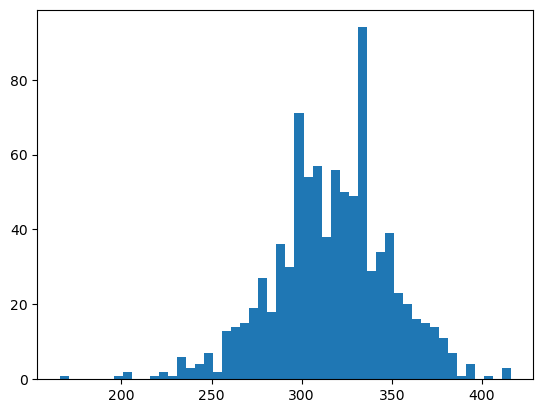

In [14]:
import matplotlib.pyplot as plt

deeps = [d[0] for d in shapes]

plt.hist(deeps, bins=50)

## Mốt số ví dụ về kích thước spacing và kích thước ảnh

In [6]:
from util import read_sitk, get_uids
import random

random.seed(42)

uids = get_uids()
random.shuffle(uids)

sample_uids = uids[:5]

In [7]:
sample_uids

['1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386']

In [8]:
for uid in sample_uids:
    # luna
    luna_path = glob.glob(f"../../luna16/LUNA16//subset*/{uid}*.mhd")[0]

    img, _, spacing, _ = read_sitk(luna_path)

    # resampling
    resampling_img_path = glob.glob(f"{resampling_paths}/subset*/{uid}*_resampling.npy")[0]
    img_resampling = np.load(resampling_img_path)

    # print result
    print(spacing, img.shape, img_resampling.shape)    

[1.79999995 0.68359375 0.68359375] (179, 512, 512) (322, 350, 350)
[1.25       0.72851598 0.72851598] (238, 512, 512) (298, 373, 373)
[1.25       0.55273402 0.55273402] (241, 512, 512) (301, 283, 283)
[1.99999988 0.60546899 0.60546899] (140, 512, 512) (280, 310, 310)
[2.5        0.56835902 0.56835902] (123, 512, 512) (308, 291, 291)
